# Spatial Data Final Project - Training and Predicting STXGB Model (One Lag)

This file contains code for predicting cases for one-week lag (t-1). The reason for choosing one lag is because of multicollienarity between different lags for the same variables.

In [1]:
#import packages we need
import pandas as pd
import numpy as np 
import sklearn
from scipy.stats import norm
import time
import os
import matplotlib.pyplot as plt

import xgboost
import pickle

from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

#utils
from functools import partial

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Set current dictionary
current_dir = '/content/drive/MyDrive/final_project/'

In [4]:
# Set output dictionary
output_dir = '/content/drive/MyDrive/final_project/'

In [5]:
# Loading final data
df = pd.read_csv(current_dir + 'data/processed/master_data.csv').iloc[:,0:-1]
df.rename(columns = {'newcases_tplus1' : 'newcases_tplus2', 'newcases_tplus2' : 'newcases_tplus3', 'newcases_tplus4' : 'newcases_tplus5', 'newcases' : 'newcases_tplus1'},inplace=True)

In [6]:
df.head()

,province,Y-W,newcases_tplus1,newcases_tminus1,newcases_tminus2,newcases_tminus3,newcases_tminus4,newcases_tplus2,newcases_tplus3,newcases_tplus5,...,workplaces_tminus4,residential_tminus1,residential_tminus2,residential_tminus3,residential_tminus4,2019employment_rate,2019intermunicipal_migration_rate,2019annual_contrib_margin,2019share_age_64,2019number_workplaces
0,South Karelia,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,67.4,-488,387.3,27.4,47995
1,Southern Ostrobothnia,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,73.8,-935,123.6,25.4,77419
2,Southern Savonia,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,68.9,-1228,143.5,30.9,50145
3,Kainuu,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,68.3,-462,857.2,28.5,27218
4,Tavastia Proper,2020-01,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,73.1,-69,197.5,25.3,64199


Get list of province names for analysis

In [7]:
provinces = list(df['province'].unique())

In [8]:
provinces

['South Karelia',
 'Southern Ostrobothnia',
 'Southern Savonia',
 'Kainuu',
 'Tavastia Proper',
 'Central Ostrobothnia',
 'Central Finland',
 'Kymenlaakso',
 'Lapland',
 'Pirkanmaa',
 'Ostrobothnia',
 'North Karelia',
 'Northern Ostrobothnia',
 'Northern Savonia',
 'Päijänne Tavastia',
 'Satakunta',
 'Uusimaa',
 'Southwest Finland']

Check list of columns

In [9]:
df.columns

Index(['province', 'Y-W', 'newcases_tplus1', 'newcases_tminus1',
       'newcases_tminus2', 'newcases_tminus3', 'newcases_tminus4',
       'newcases_tplus2', 'newcases_tplus3', 'newcases_tplus5', 'spc_tminus1',
       'spc_tminus2', 'spc_tminus3', 'spc_tminus4', 'temp_min_tminus1',
       'temp_min_tminus2', 'temp_min_tminus3', 'temp_min_tminus4',
       'temp_max_tminus1', 'temp_max_tminus2', 'temp_max_tminus3',
       'temp_max_tminus4', 'retail_tminus1', 'retail_tminus2',
       'retail_tminus3', 'retail_tminus4', 'grocery_tminus1',
       'grocery_tminus2', 'grocery_tminus3', 'grocery_tminus4',
       'parks_tminus1', 'parks_tminus2', 'parks_tminus3', 'parks_tminus4',
       'transit_tminus1', 'transit_tminus2', 'transit_tminus3',
       'transit_tminus4', 'workplaces_tminus1', 'workplaces_tminus2',
       'workplaces_tminus3', 'workplaces_tminus4', 'residential_tminus1',
       'residential_tminus2', 'residential_tminus3', 'residential_tminus4',
       '2019employment_rate', '2019

In [10]:
def choosehorizon(dataframe,pred : int,lags):
    """
    This function takes in the master dataframe and spits out the lags that you want to include,
    and then sorts the data so that it's easier to look at.
    """
    if pred not in [1,2,4]:
        print(f"Sorry, but the only available prediction horizons are 1,2 and 4 weeks ahead!")
        return None
    elif (max(lags) > 4) or (min(lags) < 1):
        if len(lags) == 0:
            print("You have specified zero lags! Nonsense!")
        else: print("Your lags are out of bounds...")
    
    lagcols = [col for col in list(dataframe.columns) if 'tminus' in col]
    
    lagschosen = []
    for lag in lags:
        lagschosen += [col for col in lagcols if str(lag) in col]
        
    lagschosen.sort()
    sociocols = [col for col in list(dataframe.columns) if '2019' in col]
    indices = ['Y-W','province']
    y = f"newcases_tplus{pred}"
    
    allcols = indices + [y] + lagschosen + sociocols
    
    # Given lags, take out data that contains NaNs due to data unavailability
    # First week when we have data is 2020-10, so add up weeks according to lags..
    max_lag = max(lags)
    # first_week = f"2020-{10+max_lag}"
    first_week = '2021-01'
    last_week = '2021-52'
    
    # Given that we are predicting into the future, we need to take off as many weeks as we
    # are predicting into the future for, because otherwise we have NaNs..
    last_week = f"2022-{10-pred}"
    
    # We also need to take care of the fact that we only have Google Mobility data up to 2021-52
    last_week_google = f"2021-52"
    
    last_effective_week = [last_week,last_week_google]
    last_effective_week.sort()
    dataframe = dataframe[(dataframe['Y-W'] >= first_week) & (dataframe['Y-W'] <= last_effective_week[0])]
    dataframe.reset_index(drop=True,inplace=True)
    return dataframe[allcols],y

In [11]:
data,depvarname = choosehorizon(df,1,[1,2,3,4]) #just to check if we select all horizons

In [12]:
google_data_list = [
"retail",
"grocery",
"parks",
"transit",
"workplaces",
"residential"
]

google_datas = []
for google_data in google_data_list:
  google_datas += [col for col in df.columns if google_data in col] 

In [13]:
google_datas

['retail_tminus1',
 'retail_tminus2',
 'retail_tminus3',
 'retail_tminus4',
 'grocery_tminus1',
 'grocery_tminus2',
 'grocery_tminus3',
 'grocery_tminus4',
 'parks_tminus1',
 'parks_tminus2',
 'parks_tminus3',
 'parks_tminus4',
 'transit_tminus1',
 'transit_tminus2',
 'transit_tminus3',
 'transit_tminus4',
 'workplaces_tminus1',
 'workplaces_tminus2',
 'workplaces_tminus3',
 'workplaces_tminus4',
 '2019number_workplaces',
 'residential_tminus1',
 'residential_tminus2',
 'residential_tminus3',
 'residential_tminus4']

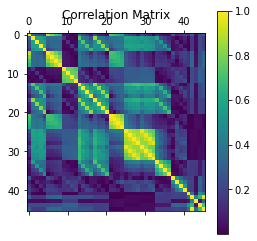

In [14]:
# Here we plot the absolute values of correlations between pairs of features.
# We can see that correlation is pretty much persistent within blocks of 
# lags of one feature, as expected. It means that we might want to see what happens in one lag
plt.matshow(np.abs(data.corr()))
plt.colorbar()
plt.title('Correlation Matrix', fontsize=12)
plt.show()

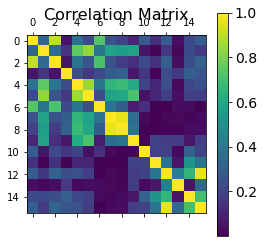

In [15]:
data_lag1,depvarname_lag1 = choosehorizon(df,1,[1])

#data_lag1.drop(columns = [colname for colname in data_lag1.columns if colname in google_data_list],inplace=True)

plt.matshow(np.abs(data_lag1.corr()))
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

We can see above that there is less multicollinearity.

In [16]:
data_lag1

,Y-W,province,newcases_tplus1,grocery_tminus1,newcases_tminus1,parks_tminus1,residential_tminus1,retail_tminus1,spc_tminus1,temp_max_tminus1,temp_min_tminus1,transit_tminus1,workplaces_tminus1,2019employment_rate,2019intermunicipal_migration_rate,2019annual_contrib_margin,2019share_age_64,2019number_workplaces
0,2021-01,South Karelia,0.743388,NaN,0.915088,NaN,NaN,NaN,1.059205,-1.042857,-3.385714,NaN,NaN,67.4,-488,387.3,27.4,47995
1,2021-01,Southern Ostrobothnia,0.000000,NaN,0.000000,NaN,NaN,NaN,0.987278,-1.257143,-4.342857,NaN,NaN,73.8,-935,123.6,25.4,77419
2,2021-01,Southern Savonia,0.000000,NaN,0.319750,NaN,NaN,NaN,1.043021,-3.014286,-7.200000,NaN,NaN,68.9,-1228,143.5,30.9,50145
3,2021-01,Kainuu,0.983755,NaN,0.000000,NaN,NaN,NaN,1.015423,0.142857,-1.642857,NaN,NaN,68.3,-462,857.2,28.5,27218
4,2021-01,Tavastia Proper,1.323183,NaN,0.902441,NaN,NaN,NaN,1.110361,-5.371429,-10.142857,NaN,NaN,73.1,-69,197.5,25.3,64199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,2021-52,Northern Savonia,3.576865,1.285714,2.636913,67.428571,9.714286,-18.428571,2.975345,-6.800000,-17.957143,-40.714286,-41.142857,69.5,-543,162.0,25.3,98975
932,2021-52,Päijänne Tavastia,3.977592,-5.857143,3.195570,4.428571,9.857143,-24.714286,3.191291,-10.514286,-20.071429,-36.714286,-43.714286,69.5,-591,222.7,26.7,77081
933,2021-52,Satakunta,3.996090,6.142857,3.507238,5.714286,10.571429,-12.714286,3.240275,-5.171429,-15.328571,-15.000000,-42.428571,71.2,-1141,63.9,27.2,86401
934,2021-52,Uusimaa,5.021271,-7.428571,4.339881,-6.142857,11.285714,-31.428571,3.041367,-6.671429,-15.028571,-47.285714,-50.142857,75.2,8144,601.0,17.6,836622


In [17]:
data_lag1.shape[0]/18

52.0

In [18]:
data = data_lag1

## Training setup

In [19]:
training_size = 30 # week
testing_size = 1 # week
num_counties = len(data.province.value_counts().index)
time_steps = 22

## Model tracking

In [19]:
train_r2_xgb = dict()
train_rmse_xgb = dict()
train_mae_xgb = dict()
test_rmse_xgb = dict()
test_mae_xgb = dict()
tuned_params_xgb = dict()

## Model grid setup

In [ ]:
# Setting Hyperparameters. Please refer to the SI for more information
xgb_params = dict(  learning_rate=np.arange(0.05,0.3,0.05),
                     #  n_estimators=np.arange(150,400,100), 
                     #gamma = np.arange(0,,1),
                    #subsample = [0.5,1],
                     max_depth=[int(i) for i in np.arange(3,10,1)])  #test on 3-10

In [ ]:
xgb_params

{'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25]),
 'max_depth': [3, 4, 5, 6, 7, 8, 9]}

## Model training

In [ ]:
for i in range(time_steps):
    
    training_df = data.iloc[:(i+training_size)*num_counties,:]
    testing_df = data.iloc[(i+training_size)*num_counties:(i+training_size+testing_size)*num_counties,:]
    
#     start_time = time.time()

    # in the 2-week prediction model, the target variable is LOG_DELTA_INC_RATE_T_14
    X_train = training_df.iloc[:,3:]
    y_train = training_df[depvarname]
    X_test = testing_df.iloc[:,3:]
    y_test = testing_df[depvarname]
    
    print(X_train.shape)
    print(y_train.shape)
    
    print(X_test.shape)
    print(y_test.shape)
    
    #scaling X
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    
    #inititalization
    xgb_model = xgboost.XGBRegressor(seed=42, verbosity=0, tree_method='gpu_hist', nthreads=-1)
    
    #cross validation
    xgb_cv = GridSearchCV(xgb_model, xgb_params, 
                                    scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=3)
    
    xgb_optimized = xgb_cv.fit(X_train, y_train)
    best_xgb = xgb_optimized.best_estimator_
    tuned_params_xgb['whole', i] = xgb_optimized.best_params_

    # save the model to disk
    filename = 'pickle_models.pkl'
    with open(filename, 'wb') as file:
      pickle.dump(xgb_optimized, file)
    
    # model evaluation for training set
    r2_train_xgb = round(best_xgb.score(X_train, y_train),2)
    train_r2_xgb['whole', i] = r2_train_xgb
    
    y_train_predicted_xgb = best_xgb.predict(X_train)
    rmse_train_xgb = (np.sqrt(mean_squared_error(y_train, y_train_predicted_xgb)))
    train_rmse_xgb['whole', i] = rmse_train_xgb
    train_mae_xgb['whole', i] =  mean_absolute_error(y_train, y_train_predicted_xgb)


    # model evaluation for test set
    y_test_predicted_xgb = best_xgb.predict(X_test)
    rmse_test_xgb = (np.sqrt(mean_squared_error(y_test, y_test_predicted_xgb)))
    test_rmse_xgb['whole', i] = rmse_test_xgb
    test_mae_xgb['whole', i] = mean_absolute_error(y_test, y_test_predicted_xgb)
        
    print(f"Finished {i}th round...")


(540, 15)
(540,)
(18, 15)
(18,)
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Finished 0th round...
(558, 15)
(558,)
(18, 15)
(18,)
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Finished 1th round...
(576, 15)
(576,)
(18, 15)
(18,)
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Finished 2th round...
(594, 15)
(594,)
(18, 15)
(18,)
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Finished 3th round...
(612, 15)
(612,)
(18, 15)
(18,)
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Finished 4th round...
(630, 15)
(630,)
(18, 15)
(18,)
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Finished 5th round...
(648, 15)
(648,)
(18, 15)
(18,)
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Finished 6th round...
(666, 15)
(666,)
(18, 15)
(18,)
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Finished 7th round...
(684, 15)
(684,)
(18, 15)
(18,)
Fitting 5 folds for each of 35 candidate

In [ ]:
tuned_params_xgb

{('whole', 0): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 1): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 2): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 3): {'learning_rate': 0.1, 'max_depth': 3},
 ('whole', 4): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 5): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 6): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 7): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 8): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 9): {'learning_rate': 0.1, 'max_depth': 3},
 ('whole', 10): {'learning_rate': 0.1, 'max_depth': 3},
 ('whole', 11): {'learning_rate': 0.1, 'max_depth': 3},
 ('whole', 12): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 13): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 14): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 15): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 16): {'learning_rate': 0.05, 'max_depth': 3},
 ('whole', 17): {'learning_rate': 0.05, 'max_

In [ ]:
print(np.exp(y_test_predicted_xgb - 1))
print(np.exp(y_test - 1))

[ 5.8575497  6.9791265  4.303841   2.4261346  9.040593   4.737215
  9.310264   8.990637   9.0957985 12.456294   9.432659   4.8408866
 11.553529   5.683113  10.564033  11.835016  12.895394  11.295389 ]
918    12.222710
919    14.056862
920     9.238991
921     7.811299
922    24.263857
923     9.782927
924    16.061831
925    20.658505
926    16.464492
927    23.108279
928    27.025203
929    14.562339
930    15.480246
931    13.155826
932    19.640471
933    20.007152
934    55.771969
935    17.378568
Name: newcases_tplus1, dtype: float64


In [ ]:
train_r2_xgb 




{('whole', 0): 0.83,
 ('whole', 1): 0.84,
 ('whole', 2): 0.84,
 ('whole', 3): 0.88,
 ('whole', 4): 0.84,
 ('whole', 5): 0.84,
 ('whole', 6): 0.84,
 ('whole', 7): 0.84,
 ('whole', 8): 0.84,
 ('whole', 9): 0.88,
 ('whole', 10): 0.88,
 ('whole', 11): 0.87,
 ('whole', 12): 0.84,
 ('whole', 13): 0.84,
 ('whole', 14): 0.84,
 ('whole', 15): 0.84,
 ('whole', 16): 0.85,
 ('whole', 17): 0.85,
 ('whole', 18): 0.86,
 ('whole', 19): 0.86,
 ('whole', 20): 0.87,
 ('whole', 21): 0.88}

In [ ]:
train_rmse_xgb 


{('whole', 0): 0.2829178867077689,
 ('whole', 1): 0.28431602936046796,
 ('whole', 2): 0.2833988260969554,
 ('whole', 3): 0.24659507788885607,
 ('whole', 4): 0.2863683503162136,
 ('whole', 5): 0.28578310291373604,
 ('whole', 6): 0.28614703481184345,
 ('whole', 7): 0.2844923991408448,
 ('whole', 8): 0.2858196164263135,
 ('whole', 9): 0.25250173371684875,
 ('whole', 10): 0.2536531091045494,
 ('whole', 11): 0.2574881694684492,
 ('whole', 12): 0.29446102158275456,
 ('whole', 13): 0.2945321880039351,
 ('whole', 14): 0.2988765920735471,
 ('whole', 15): 0.29491001330136163,
 ('whole', 16): 0.29658172480751477,
 ('whole', 17): 0.29507791102282055,
 ('whole', 18): 0.29517960821154005,
 ('whole', 19): 0.29581794835838143,
 ('whole', 20): 0.2955987642909134,
 ('whole', 21): 0.2982433198142853}

In [ ]:

test_rmse_xgb 

{('whole', 0): 0.33948001177268883,
 ('whole', 1): 0.266820992526849,
 ('whole', 2): 0.3255459118316146,
 ('whole', 3): 0.3845784777710408,
 ('whole', 4): 0.298872340304897,
 ('whole', 5): 0.3483323894176335,
 ('whole', 6): 0.3297633257199004,
 ('whole', 7): 0.3320828204618969,
 ('whole', 8): 0.47599051036465767,
 ('whole', 9): 0.420107385456296,
 ('whole', 10): 0.3103675044264326,
 ('whole', 11): 0.386988365316465,
 ('whole', 12): 0.35086928456507593,
 ('whole', 13): 0.43663365983348706,
 ('whole', 14): 0.24717806299819556,
 ('whole', 15): 0.36581780585851426,
 ('whole', 16): 0.33242294374067444,
 ('whole', 17): 0.39702335604561084,
 ('whole', 18): 0.3431144935331873,
 ('whole', 19): 0.4217131643799624,
 ('whole', 20): 0.489271114076172,
 ('whole', 21): 0.8268933336934147}

In [5]:
test_rmse = { 0: 0.33948001177268883,
  1: 0.266820992526849,
  2: 0.3255459118316146,
  3: 0.3845784777710408,
  4: 0.298872340304897,
  5: 0.3483323894176335,
  6: 0.3297633257199004,
  7: 0.3320828204618969,
  8: 0.47599051036465767,
  9: 0.420107385456296,
  10: 0.3103675044264326,
  11: 0.386988365316465,
  12: 0.35086928456507593,
  13: 0.43663365983348706,
  14: 0.24717806299819556,
  15: 0.36581780585851426,
  16: 0.33242294374067444,
  17: 0.39702335604561084,
  18: 0.3431144935331873,
  19: 0.4217131643799624,
  20: 0.489271114076172,
  21: 0.8268933336934147}

In [6]:
sum_rmse=0
for key in test_rmse.keys():
  sum_rmse += test_rmse[key]

In [7]:
sum_rmse/22 #get the average of the rmse over all weeks

0.3831757842770303

In [ ]:
test_mae_xgb

{('whole', 0): 0.2172567554019549,
 ('whole', 1): 0.219462521942398,
 ('whole', 2): 0.23671255898554833,
 ('whole', 3): 0.2895963554023798,
 ('whole', 4): 0.2383447950770353,
 ('whole', 5): 0.2660368150581455,
 ('whole', 6): 0.25321344634101656,
 ('whole', 7): 0.27648493300891414,
 ('whole', 8): 0.4075639353652807,
 ('whole', 9): 0.2861934910685128,
 ('whole', 10): 0.22803808662291544,
 ('whole', 11): 0.29328833294527673,
 ('whole', 12): 0.3135776182842094,
 ('whole', 13): 0.3852207270123395,
 ('whole', 14): 0.22509905215179613,
 ('whole', 15): 0.30168618995062735,
 ('whole', 16): 0.2834138788873604,
 ('whole', 17): 0.30514626529534516,
 ('whole', 18): 0.2981438807359049,
 ('whole', 19): 0.3542475586447938,
 ('whole', 20): 0.38253970674090343,
 ('whole', 21): 0.7775728162265687}

In [8]:
test_mae = { 0: 0.2172567554019549,
  1: 0.219462521942398,
  2: 0.23671255898554833,
  3: 0.2895963554023798,
  4: 0.2383447950770353,
  5: 0.2660368150581455,
  6: 0.25321344634101656,
  7: 0.27648493300891414,
  8: 0.4075639353652807,
  9: 0.2861934910685128,
  10: 0.22803808662291544,
  11: 0.29328833294527673,
  12: 0.3135776182842094,
  13: 0.3852207270123395,
  14: 0.22509905215179613,
  15: 0.30168618995062735,
  16: 0.2834138788873604,
  17: 0.30514626529534516,
  18: 0.2981438807359049,
  19: 0.3542475586447938,
  20: 0.38253970674090343,
  21: 0.7775728162265687}

In [9]:
sum=0
for key in test_mae.keys():
  sum += test_mae[key]


In [10]:
print(sum/22) #get the average of the mae over all weeks

0.31085635096132846


In [ ]:
#save all results to pkl
results = [train_r2_xgb,
train_rmse_xgb,
train_mae_xgb,
test_rmse_xgb,
test_mae_xgb,
tuned_params_xgb,]

The following function fits an stxgb model using the parameters we trained above. The process will be the same except we don't perform gridsearch cross validation over the parameter space here. We simply fit and on the training set and then generate predictions using the test set.

In [20]:
def get_stxgb_results(time_steps, data, learning_rate, max_depth):
  i = time_steps
  training_df = data.iloc[:(i+training_size)*num_counties,:]
  testing_df = data.iloc[(i+training_size)*num_counties:(i+training_size+testing_size)*num_counties,:]


  X_train = training_df.iloc[:,3:]
  y_train = training_df[depvarname]
  X_test = testing_df.iloc[:,3:]
  y_test = testing_df[depvarname]


  
  #scaling X
  scaler = MinMaxScaler()
  X_train_df = X_train
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  
  
  #inititalization
  xgb_model = xgboost.XGBRegressor(seed=42, verbosity=0, tree_method='gpu_hist', nthreads=-1, learning_rate=learning_rate, max_depth=max_depth)
  xgb_model.fit(X_train, y_train)

  sorted_idx = xgb_model.feature_importances_.argsort()
  plt.figure(figsize=(10,10))
  plt.barh(X_train_df.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
  plt.xlabel("Xgboost Feature Importance for model in week: {i}".format(i=i+30))

  # model evaluation for test set
  y_test_predicted_xgb = xgb_model.predict(X_test)


  predicted = np.exp(y_test_predicted_xgb )-1 #return real cases (not log scaled)
  real = np.exp(y_test)-1
  return predicted, real

In [21]:
tuned_xgb_params = { 0: {'learning_rate': 0.05, 'max_depth': 3},
  1: {'learning_rate': 0.05, 'max_depth': 3},
  2: {'learning_rate': 0.05, 'max_depth': 3},
  3: {'learning_rate': 0.1, 'max_depth': 3},
  4: {'learning_rate': 0.05, 'max_depth': 3},
  5: {'learning_rate': 0.05, 'max_depth': 3},
  6: {'learning_rate': 0.05, 'max_depth': 3},
  7: {'learning_rate': 0.05, 'max_depth': 3},
  8: {'learning_rate': 0.05, 'max_depth': 3},
  9: {'learning_rate': 0.1, 'max_depth': 3},
  10: {'learning_rate': 0.1, 'max_depth': 3},
  11: {'learning_rate': 0.1, 'max_depth': 3},
  12: {'learning_rate': 0.05, 'max_depth': 3},
  13: {'learning_rate': 0.05, 'max_depth': 3},
  14: {'learning_rate': 0.05, 'max_depth': 3},
  15: {'learning_rate': 0.05, 'max_depth': 3},
  16: {'learning_rate': 0.05, 'max_depth': 3},
  17: {'learning_rate': 0.05, 'max_depth': 3},
  18: {'learning_rate': 0.05, 'max_depth': 3},
  19: {'learning_rate': 0.05, 'max_depth': 3},
  20: {'learning_rate': 0.05, 'max_depth': 3},
  21: {'learning_rate': 0.05, 'max_depth': 3}} #saved parameters from a previous training run

In [22]:
result_dict = {'province': provinces} #generate dataframe to save results
result_df = pd.DataFrame(result_dict)
result_df

,province
0,South Karelia
1,Southern Ostrobothnia
2,Southern Savonia
3,Kainuu
4,Tavastia Proper
5,Central Ostrobothnia
6,Central Finland
7,Kymenlaakso
8,Lapland
9,Pirkanmaa


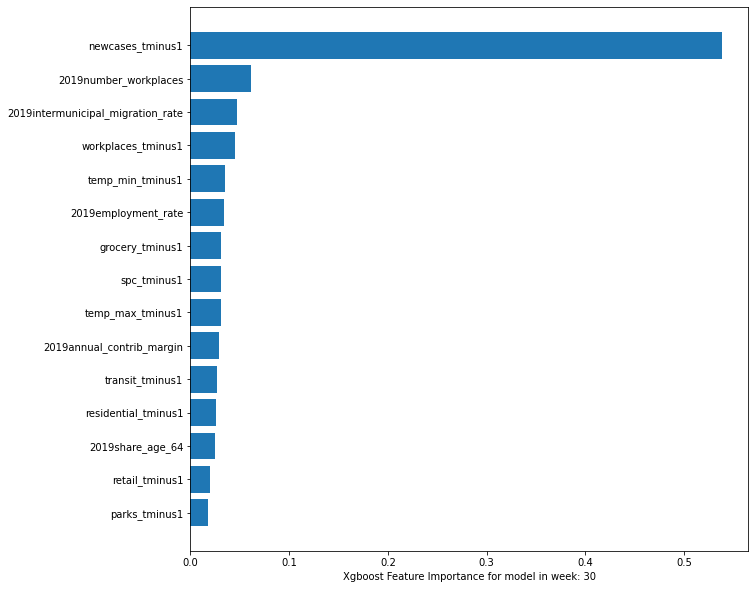

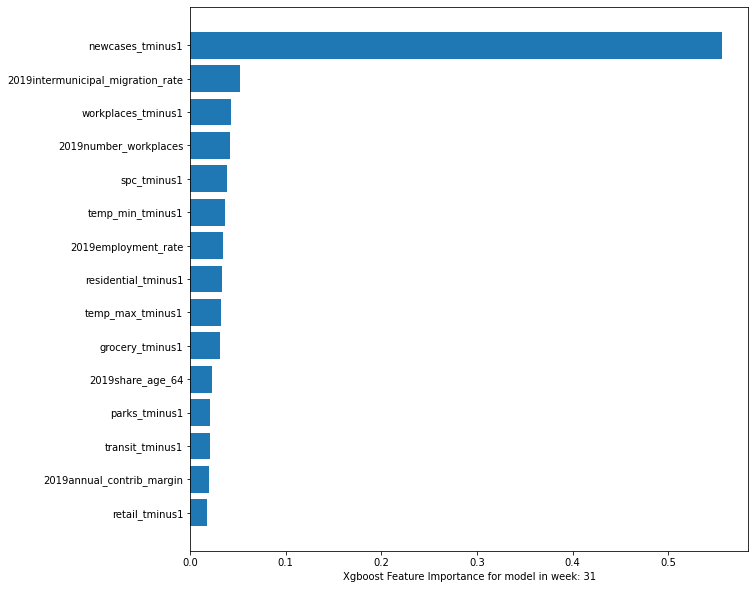

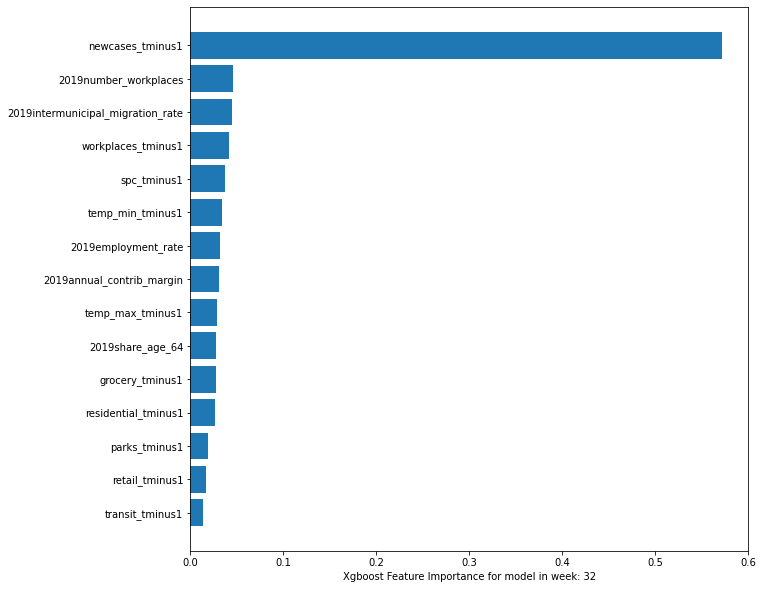

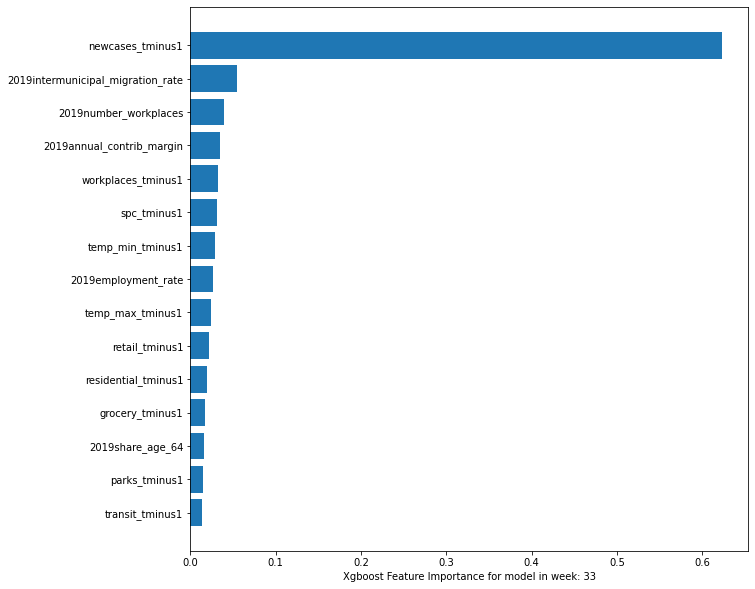

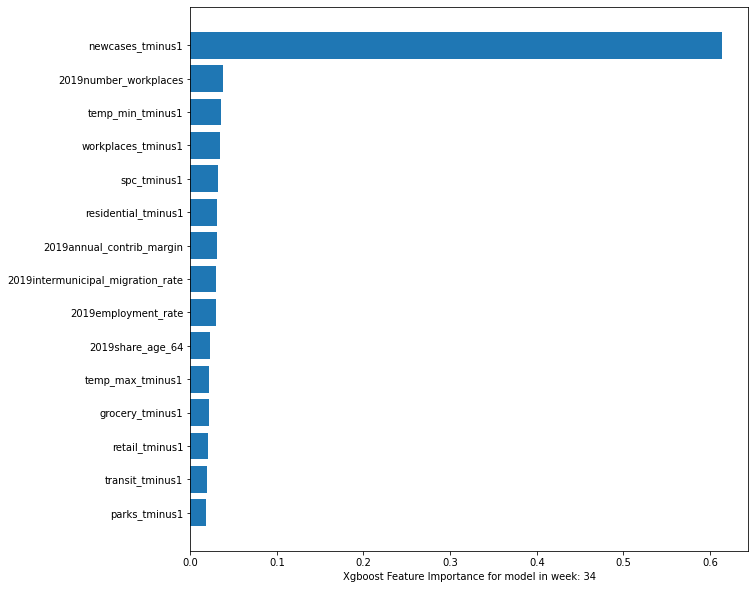

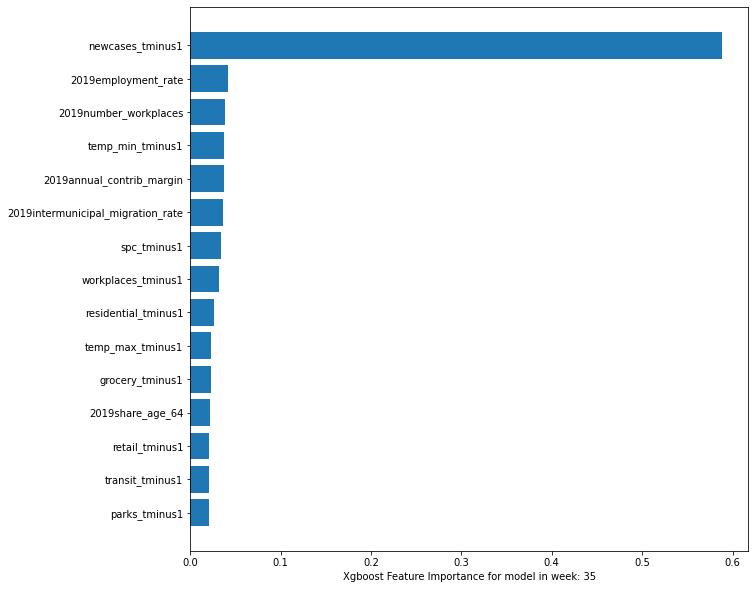

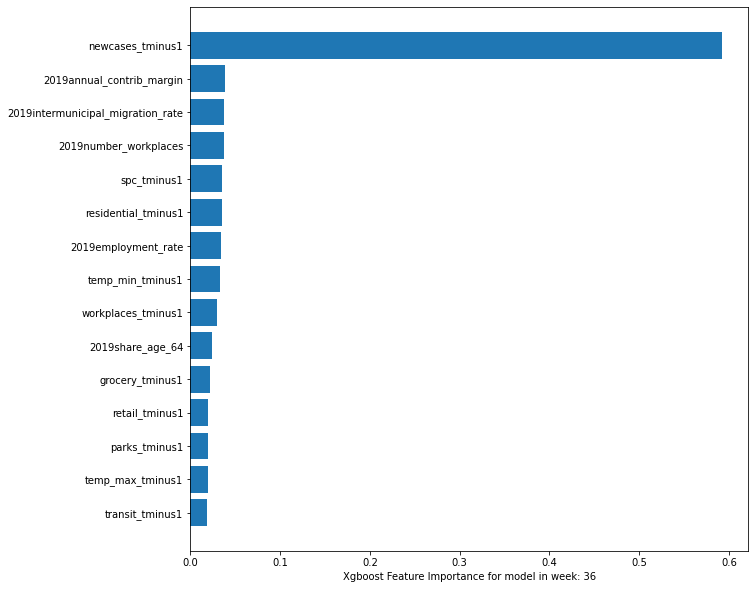

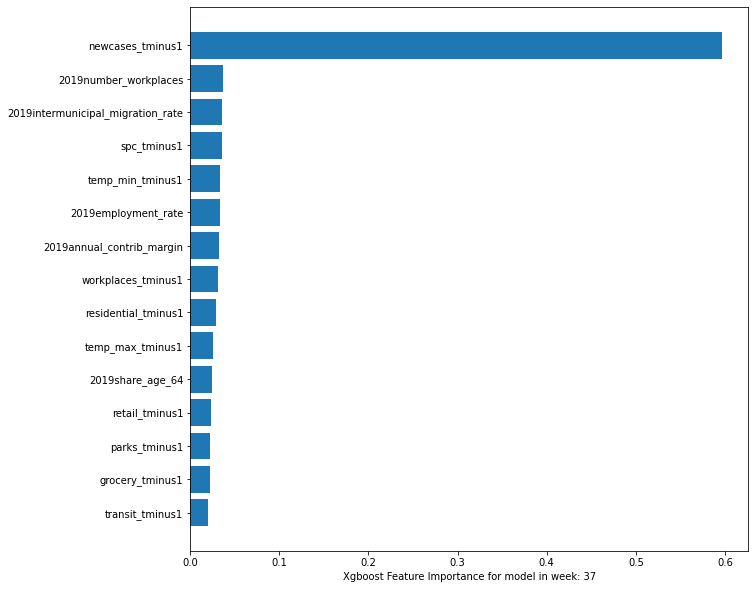

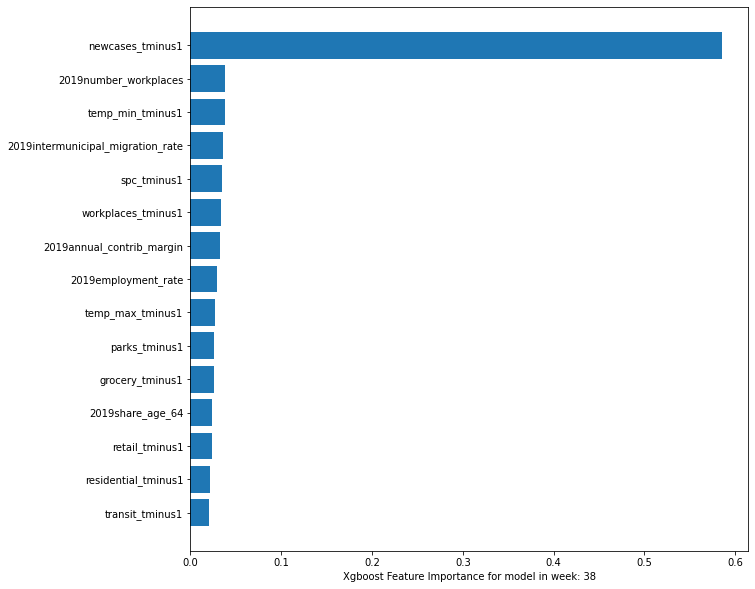

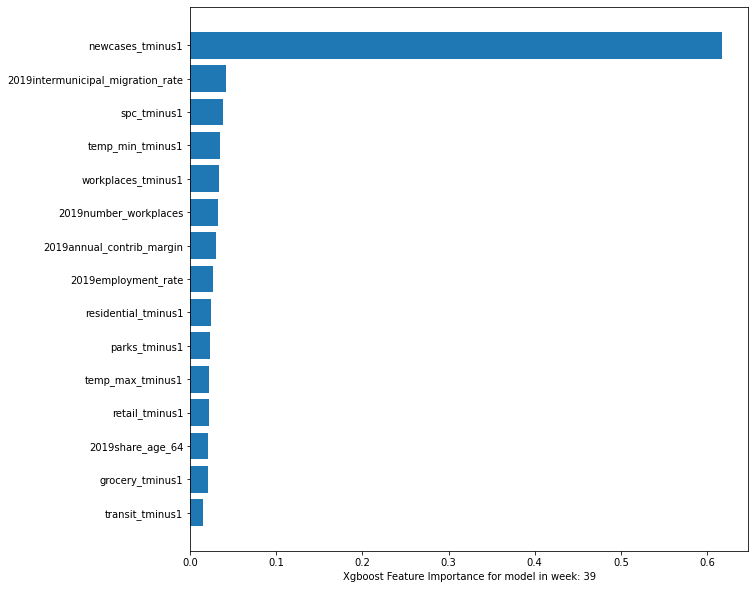

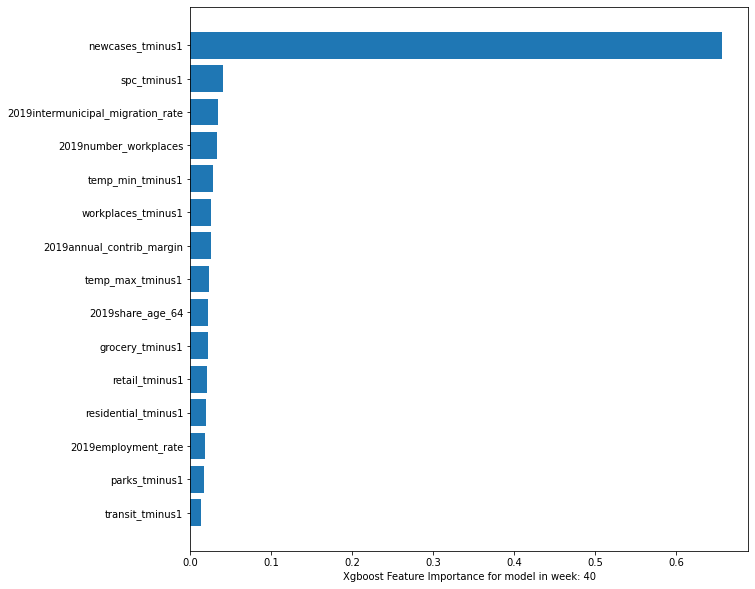

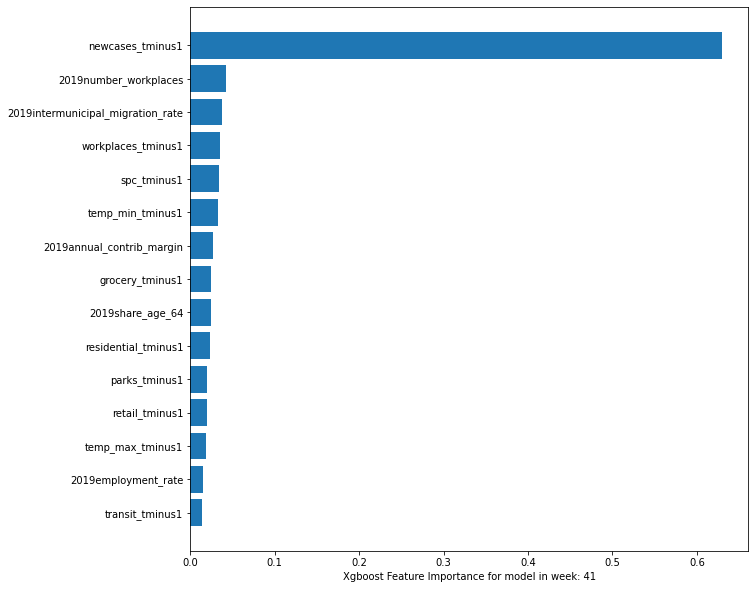

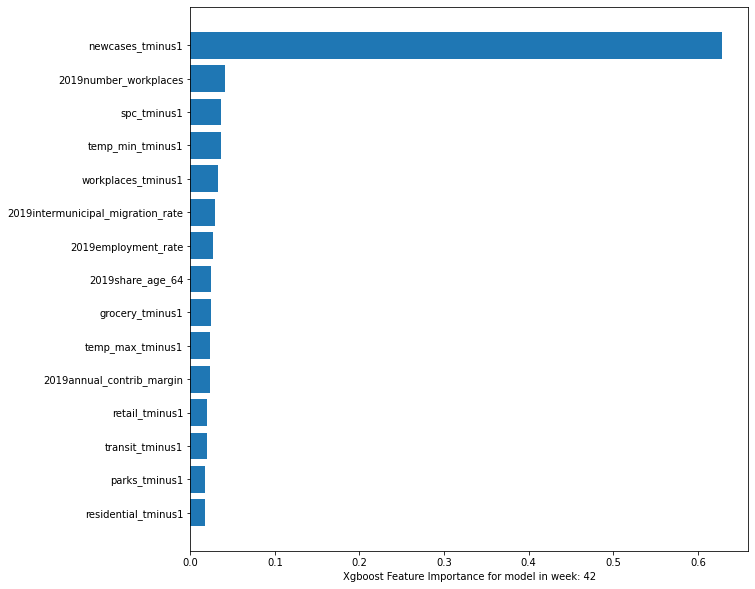

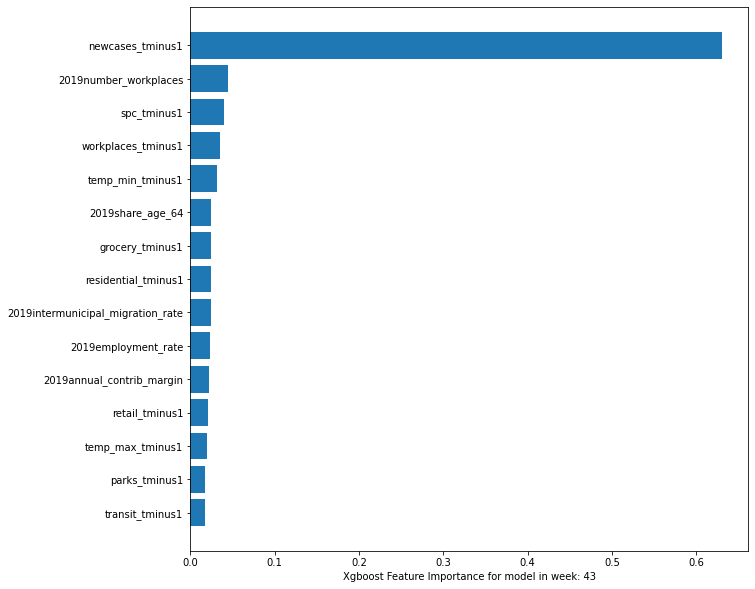

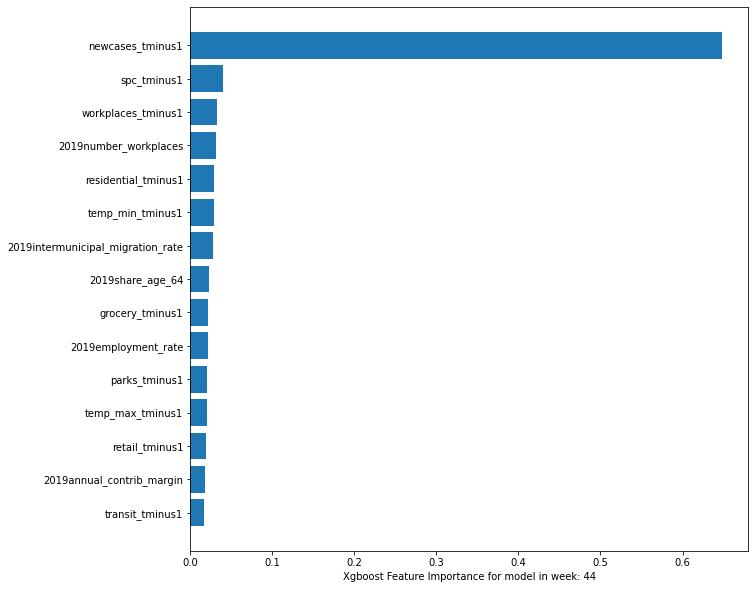

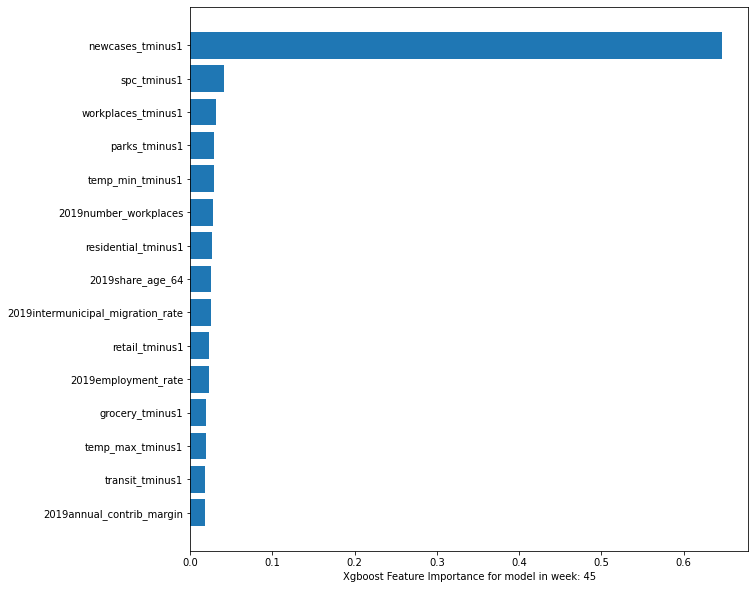

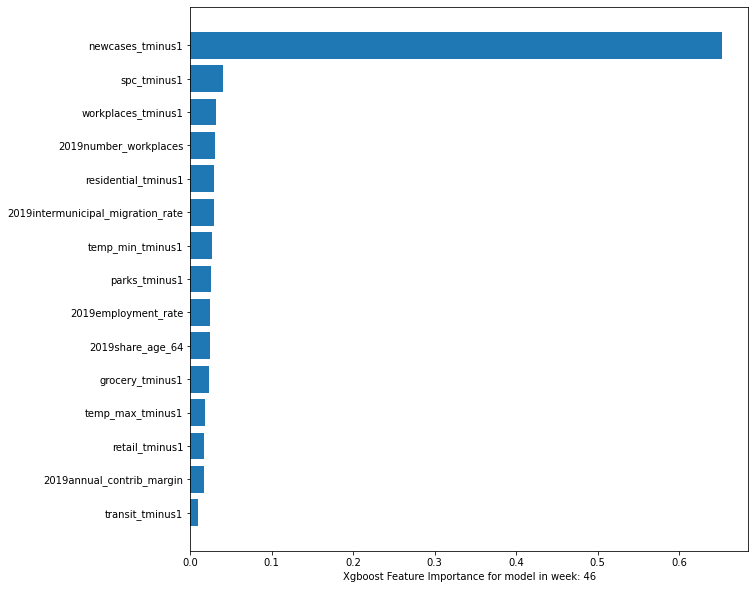

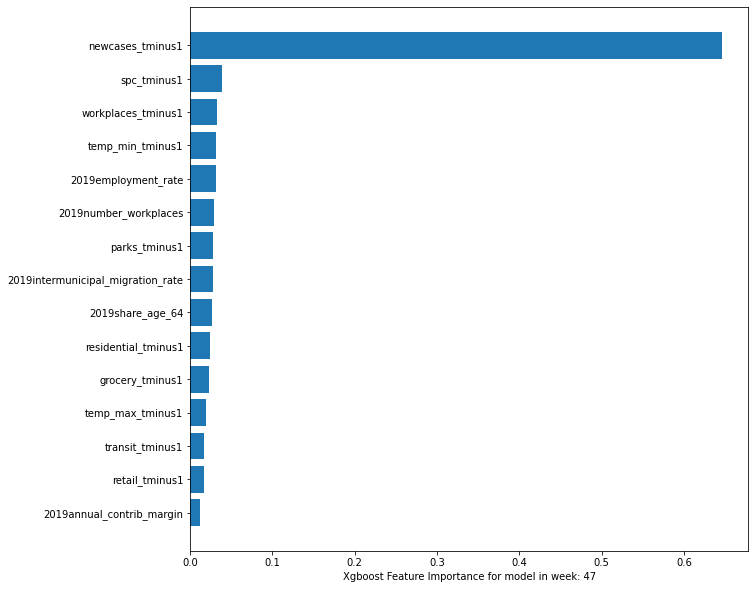

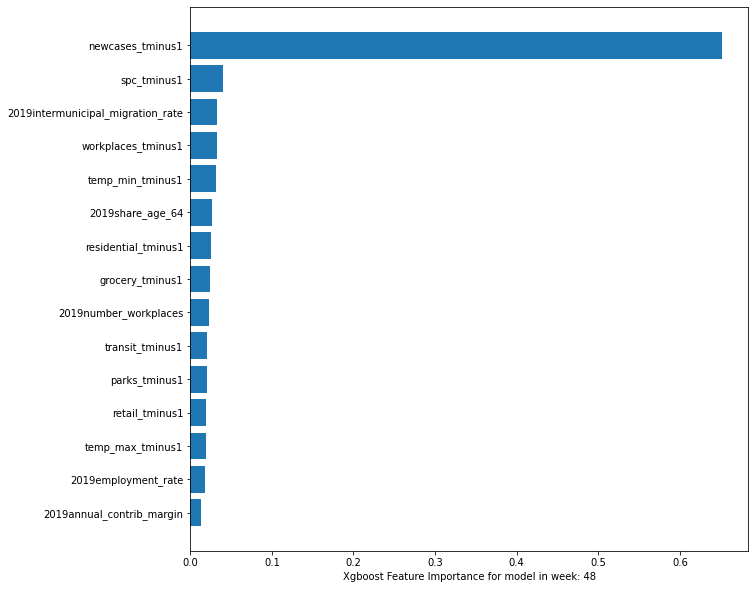

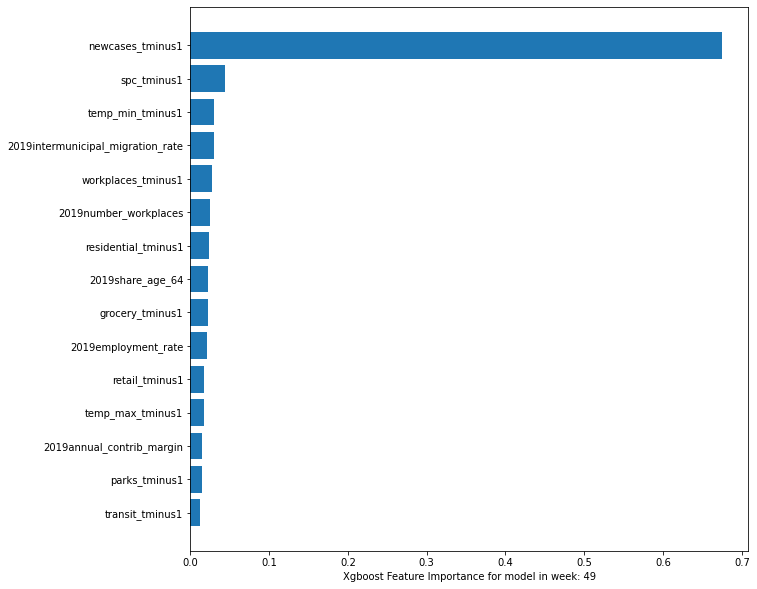

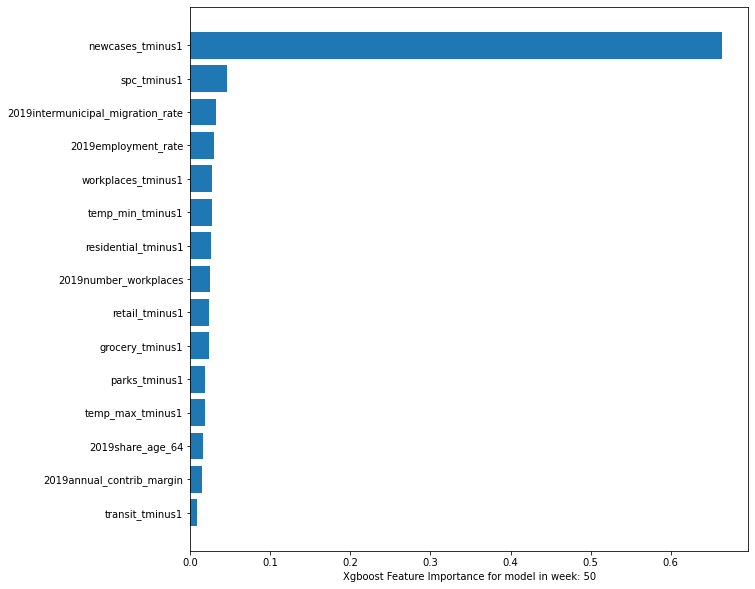

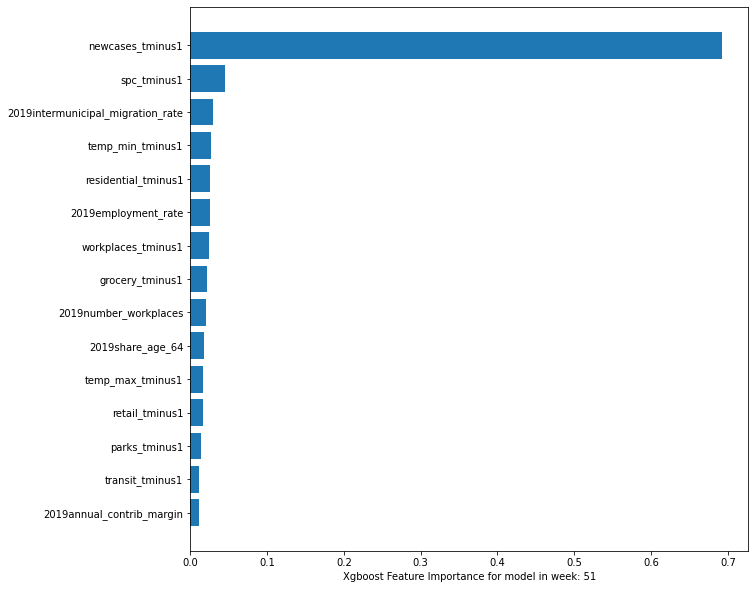

In [23]:
#get stxgb results over all 22 time steps
for i in range(time_steps):
  learning_rate = tuned_xgb_params[i]['learning_rate']
  max_depth = tuned_xgb_params[i]['max_depth']
  predicted, real = get_stxgb_results(i, data,learning_rate,max_depth)
  result_week_dict = {'newcases{t}_real'.format(t=i+31): real, 'newcases{t}_predicted'.format(t=i+31): predicted}
  result_week_df = pd.DataFrame(result_week_dict)
  result_week_df.reset_index(drop=True,inplace=True)
  result_df = pd.concat([result_df, result_week_df],axis=1)
  #df1
  #result_week_df







Aggregating Cases for all of Finland for visualizations

In [30]:
df2 = result_df.sum() #sum over all regions for every week



In [31]:
df2

province                South KareliaSouthern OstrobothniaSouthern Sav...
newcases31_real                                                 44.839139
newcases31_predicted                                            38.139801
newcases32_real                                                 44.780629
newcases32_predicted                                            42.010323
newcases33_real                                                 42.894047
newcases33_predicted                                            41.150288
newcases34_real                                                 40.881811
newcases34_predicted                                            38.036091
newcases35_real                                                  37.70642
newcases35_predicted                                            35.192406
newcases36_real                                                 33.377365
newcases36_predicted                                            33.379471
newcases37_real                       

In [32]:
result_dict = df2.to_dict() #save as dict to remove provinces

In [33]:
result_dict.pop('province', None) #remove provinces

'South KareliaSouthern OstrobothniaSouthern SavoniaKainuuTavastia ProperCentral OstrobothniaCentral FinlandKymenlaaksoLaplandPirkanmaaOstrobothniaNorth KareliaNorthern OstrobothniaNorthern SavoniaPäijänne TavastiaSatakuntaUusimaaSouthwest Finland'

In [34]:
print(result_dict)

{'newcases31_real': 44.839138544583825, 'newcases31_predicted': 38.139801025390625, 'newcases32_real': 44.78062948430971, 'newcases32_predicted': 42.01032257080078, 'newcases33_real': 42.89404669613391, 'newcases33_predicted': 41.15028762817383, 'newcases34_real': 40.8818114534463, 'newcases34_predicted': 38.03609085083008, 'newcases35_real': 37.70642038920692, 'newcases35_predicted': 35.192405700683594, 'newcases36_real': 33.37736536432883, 'newcases36_predicted': 33.37947082519531, 'newcases37_real': 33.39829478352383, 'newcases37_predicted': 29.923994064331055, 'newcases38_real': 33.95429415644552, 'newcases38_predicted': 28.819252014160156, 'newcases39_real': 43.688126927111405, 'newcases39_predicted': 30.462888717651367, 'newcases40_real': 48.91436012908504, 'newcases40_predicted': 46.940391540527344, 'newcases41_real': 41.284197244358666, 'newcases41_predicted': 44.23787307739258, 'newcases42_real': 38.702605971805475, 'newcases42_predicted': 36.25827407836914, 'newcases43_real':

In [35]:
real_cases = []
predicted_cases = [] #separate real and predicted cases from the data we have
for key in result_dict.keys():
  if 'real' in key:
    real_cases.append(result_dict[key])
  else:
    predicted_cases.append(result_dict[key])



In [36]:
x_axis = np.arange(31, 53, 1) #generate x axis

In [37]:
x_axis

array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52])

The following code plots the predicted and real cases over all of Finland:

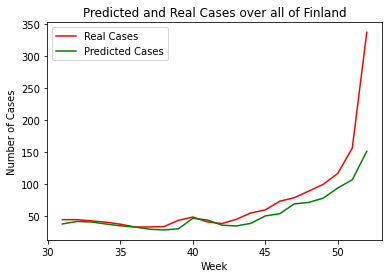

In [39]:
fig, ax = plt.subplots()

ax.plot(x_axis, real_cases, color= 'red', label='Real Cases')
ax.plot(x_axis, predicted_cases, color= 'green', label='Predicted Cases')
ax.legend(loc = 'upper left')

plt.xlabel("Week")
plt.ylabel("Number of Cases")
plt.title("Predicted and Real Cases over all of Finland")
plt.show()